In [1]:
%matplotlib widget


import os
import numpy as np
import pandas as pd
import itertools as it
from glob import glob
import matplotlib.pyplot as plt
from sbpy.calib import Sun
from astropy.visualization import simple_norm, imshow_norm
from astropy import units as u
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.time import Time
from tqdm import tqdm

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

from lvmdrp.core.constants import LVM_UNAM_URL
from lvmdrp.utils.examples import fetch_example_data, get_frames_metadata, fix_lamps_metadata, get_masters_metadata

from lvmdrp.core import rss, image, spectrum1d, tracemask

plt.style.use("seaborn-v0_8-talk")

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = "./data"
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_main_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.fits")
out_calib_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{exptime}.fits")
out_arc_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{lamps}.fits")

# overwrite or not
OVERWRITE = False

In [3]:
# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "lco_com"), ignore_cache=False).to_pandas()
frames_table = frames_table.loc[~frames_table.mjd.isin([60008,60009,60037,60038])]
# fix arc lamps metadata
fix_lamps_metadata(metadata=frames_table, lamp_names="argon neon ldls hgne xenon krypton".split())

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/frames_table.pkl'


# Bias and Dark frames

Here we analyse the structure in individual bias and dark frames, the variations in time and 'room' temperature.

In [4]:
biases = frames_table.query("imagetyp=='bias'")

# extract observation time and temperature
if not os.path.isfile("data/biases.pkl") or OVERWRITE:
    obstime, temp = [], []
    os_meds, os_stds = [], []
    sc_meds, sc_stds = [], []
    for _, bias_frame in tqdm(biases.iterrows(), total=len(biases), desc="reading bias header", unit="frame", ascii=True):
        bias_image = image.loadImage(out_main_path.format(kind="pbias", camera=bias_frame.camera, expnum=bias_frame.expnum))

        # extract additional metadata
        obstime.append(Time(bias_image._header["OBSTIME"]).to_datetime())
        temp.append(bias_image._header["LABTEMP"])

        # get median and standard deviation counts per quadrant
        os_med = bias_image._header["AMP? OVERSCAN"]
        os_std = bias_image._header["AMP? OVERSCAN_STD"]
        sections = bias_image._header["AMP? TRIMSEC"]
        quads = [bias_image.getSection(sections[k]) for k in sections]
        sc_med = [np.ma.median(np.ma.masked_array(quad._data, mask=quad._mask)) for quad in quads]
        sc_std = [np.ma.std(np.ma.masked_array(quad._data, mask=quad._mask)) for quad in quads]

        os_meds.append(os_med)
        os_stds.append(os_std)
        sc_meds.append(sc_med)
        sc_stds.append(sc_std)

    biases["temp"] = temp
    biases["obstime"] = obstime
    biases["os_med"] = os_meds
    biases["os_std"] = os_stds
    biases["sc_med"] = sc_meds
    biases["sc_std"] = sc_stds
    biases.sort_values(["camera", "obstime"], inplace=True)
    biases.to_pickle("data/biases.pkl")
else:
    biases = pd.read_pickle("data/biases.pkl")

In [5]:
darks = frames_table.query("imagetyp=='dark'")

# extract observation time and temperature
if not os.path.isfile("data/darks.pkl") or OVERWRITE:
    obstime, temp = [], []
    er_meds, er_stds = [], []
    sc_meds, sc_stds = [], []
    for _, dark_frame in tqdm(darks.iterrows(), total=len(darks), desc="reading dark header", unit="frame", ascii=True):
        dark_image = image.loadImage(out_main_path.format(kind="pdark", camera=dark_frame.camera, expnum=dark_frame.expnum))

        # extract additional metadata
        obstime.append(Time(dark_image._header["OBSTIME"]).to_datetime())
        temp.append(dark_image._header["LABTEMP"])

        # get median and standard deviation counts per quadrant
        sections = dark_image._header["AMP? TRIMSEC"]
        quads = [dark_image.getSection(sections[k]) for k in sections]
        sc_med = [np.ma.median(np.ma.masked_array(quad._data, mask=quad._mask)) for quad in quads]
        sc_std = [np.ma.std(np.ma.masked_array(quad._data, mask=quad._mask)) for quad in quads]
        er_med = [np.ma.median(np.ma.masked_array(quad._error, mask=quad._mask)) for quad in quads]
        er_std = [np.ma.std(np.ma.masked_array(quad._error, mask=quad._mask)) for quad in quads]

        er_meds.append(er_med)
        er_stds.append(er_std)
        sc_meds.append(sc_med)
        sc_stds.append(sc_std)

    darks["temp"] = temp
    darks["obstime"] = obstime
    darks["er_med"] = er_meds
    darks["er_std"] = er_stds
    darks["sc_med"] = sc_meds
    darks["sc_std"] = sc_stds
    darks.sort_values(["camera", "obstime"], inplace=True)
    darks.to_pickle("data/darks.pkl")
else:
    darks = pd.read_pickle("data/darks.pkl")

[WARNING]: FixedFormatter should only be used together with FixedLocator (UserWarning)


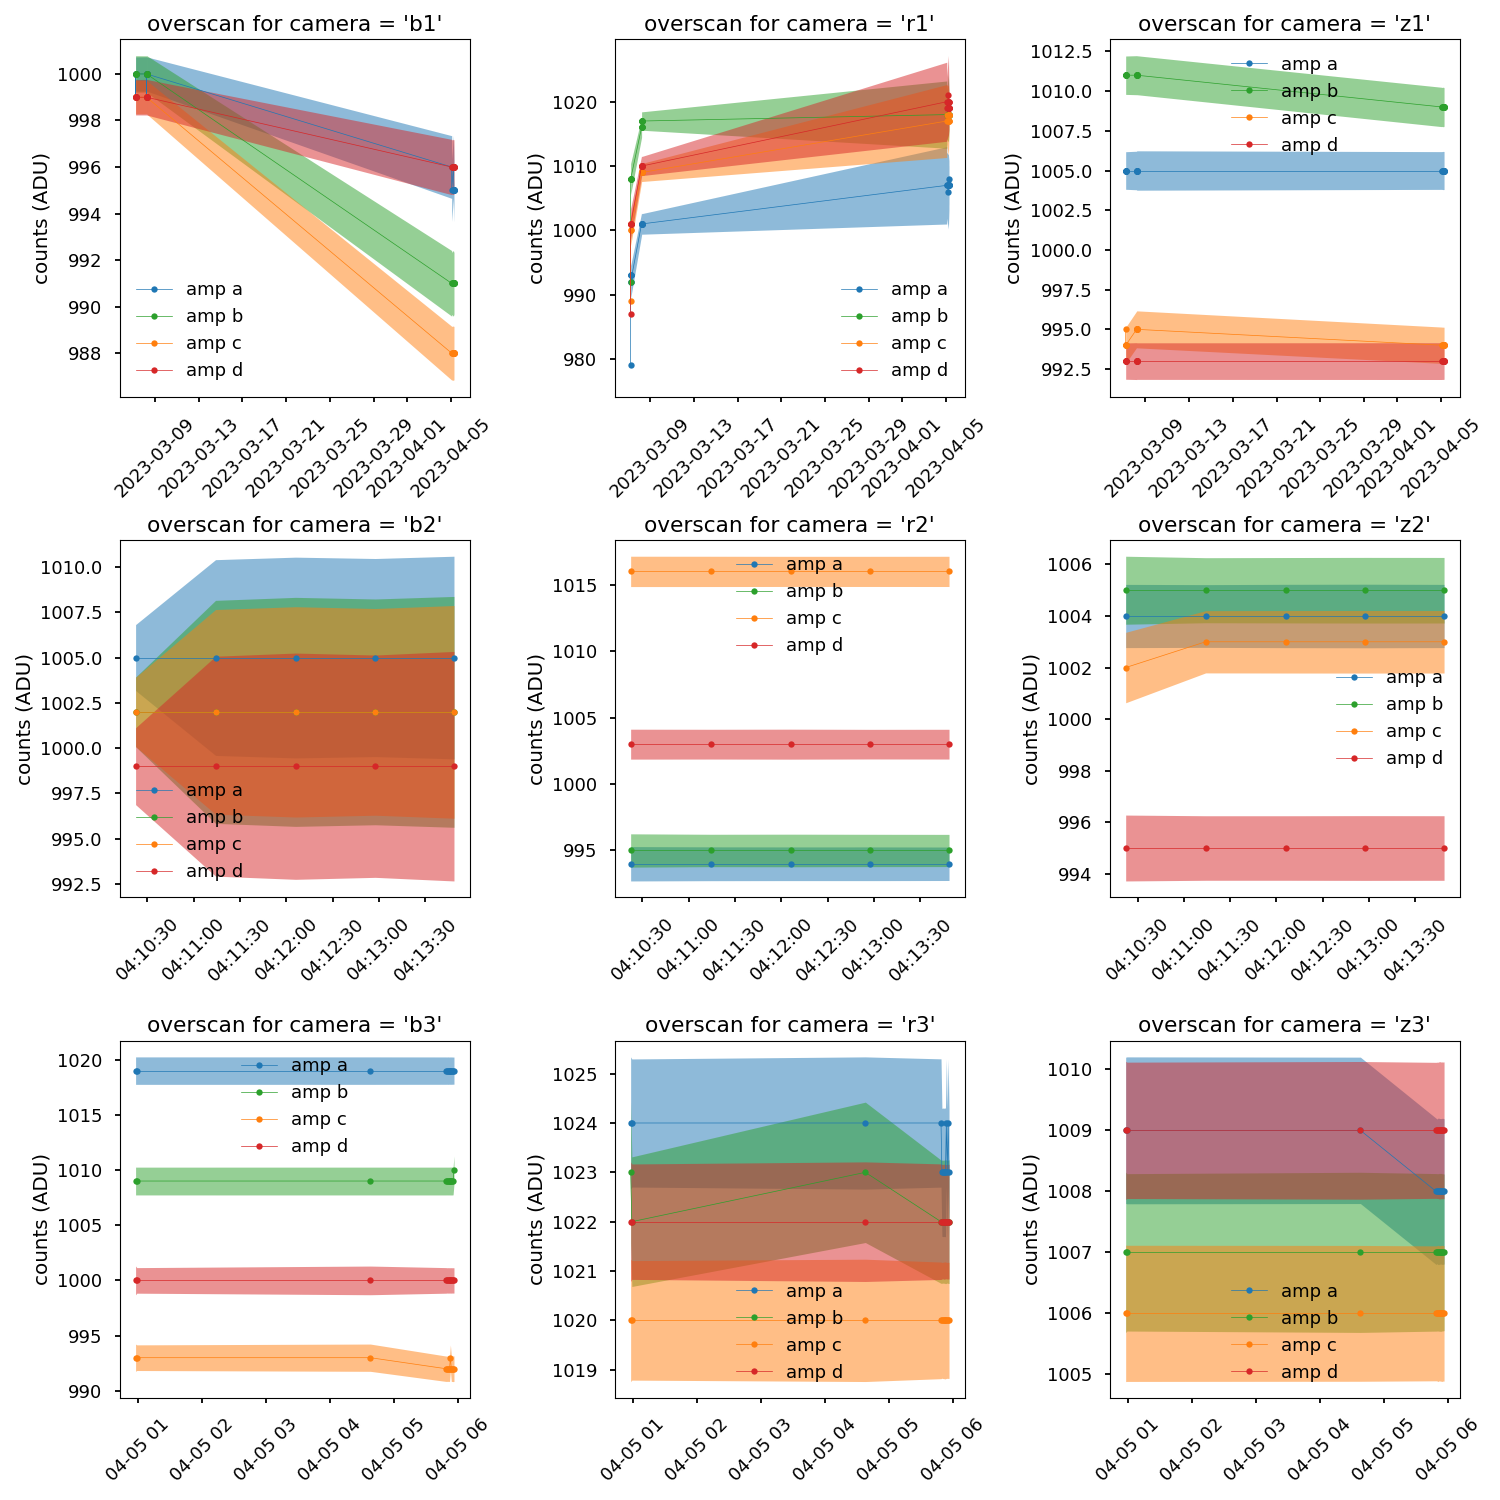

In [6]:

fig, axs = plt.subplots(3, 3, figsize=(15,15))
axs = axs.T.flatten()

quad_colors = ["tab:blue", "tab:green", "tab:orange", "tab:red"]
bias_groups = biases.groupby("camera")
for i, camera in enumerate(bias_groups.groups):
    bias_group = bias_groups.get_group(camera)
    
    axs[i].set_title(f"overscan for {camera = }")
    
    for j in range(4):
        med, std = bias_group.os_med.apply(lambda l: l[j]), bias_group.os_std.apply(lambda l: l[j])
        axs[i].fill_between(bias_group.obstime.values, med-std, med+std, lw=0, color=quad_colors[j], alpha=0.5)
        axs[i].plot(bias_group.obstime.values, med, ".-", lw=0.5, color=quad_colors[j], label=f"amp {'abcd'[j]}")
    
    axs[i].legend(loc=0, frameon=False)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
    axs[i].set_ylabel("counts (ADU)")

fig.tight_layout()

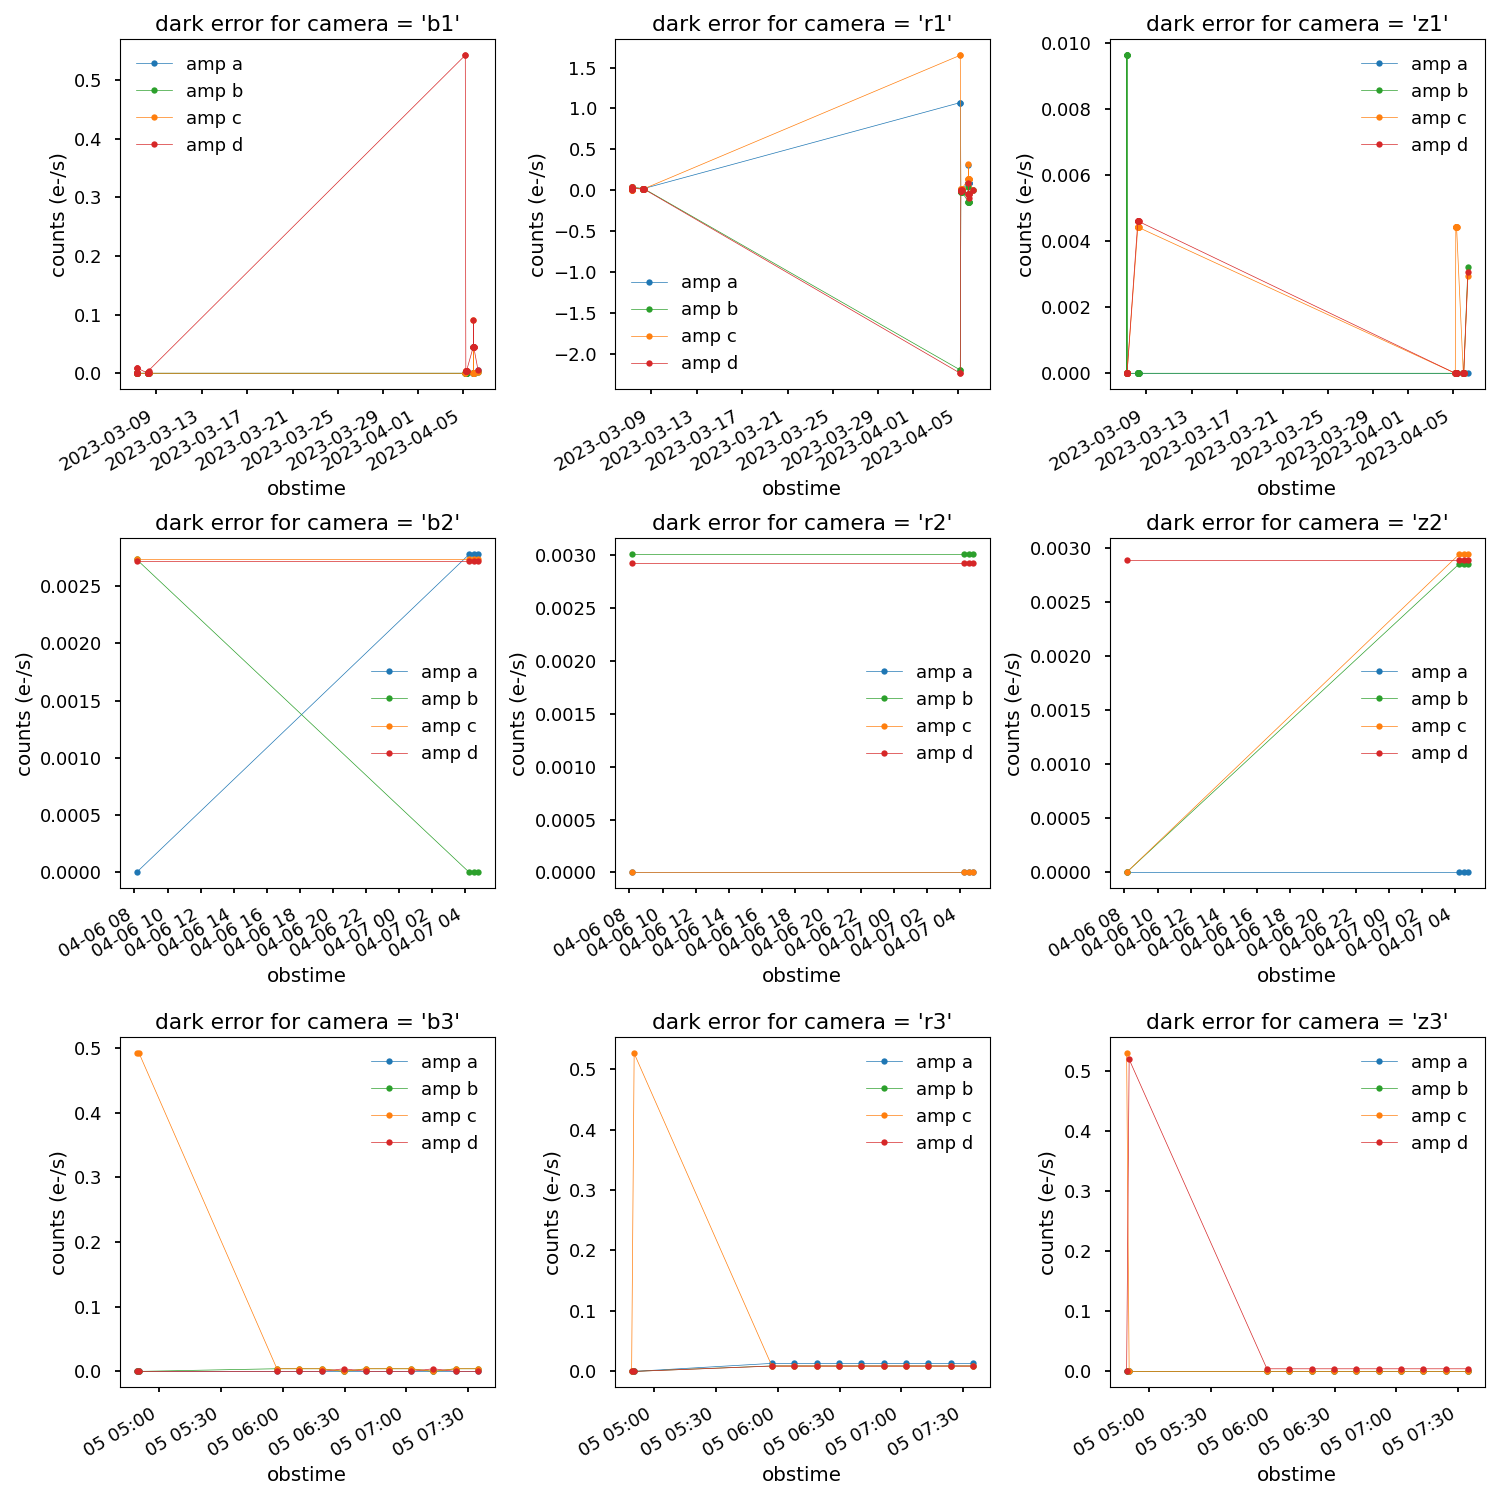

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(15,15))
axs = axs.T.flatten()

quad_colors = ["tab:blue", "tab:green", "tab:orange", "tab:red"]
dark_groups = darks.groupby("camera")
for i, camera in enumerate(dark_groups.groups):
    dark_group = dark_groups.get_group(camera)
    
    axs[i].set_title(f"dark error for {camera = }")
    
    for j in range(4):
        med = pd.Series(dark_group.sc_med.apply(lambda l: l[j]).values, dark_group.obstime) / dark_group.exptime.values
        std = pd.Series(dark_group.sc_std.apply(lambda l: l[j]).values, dark_group.obstime) / dark_group.exptime.values
        
        med.plot(ax=axs[i], style=".-", lw=0.5, color=quad_colors[j], label=f"amp {'abcd'[j]}")
        # # axs[i].fill_between(dark_group.obstime.values, med-std, med+std, lw=0, color=quad_colors[j], alpha=0.5)
        # axs[i].plot(dark_group.obstime.dt.time, med, "o-", lw=0.5, color=quad_colors[j], label=f"amp {'abcd'[j]}")
    
    axs[i].legend(loc=0, frameon=False)
    axs[i].set_ylabel("counts (e-/s)")

fig.tight_layout()

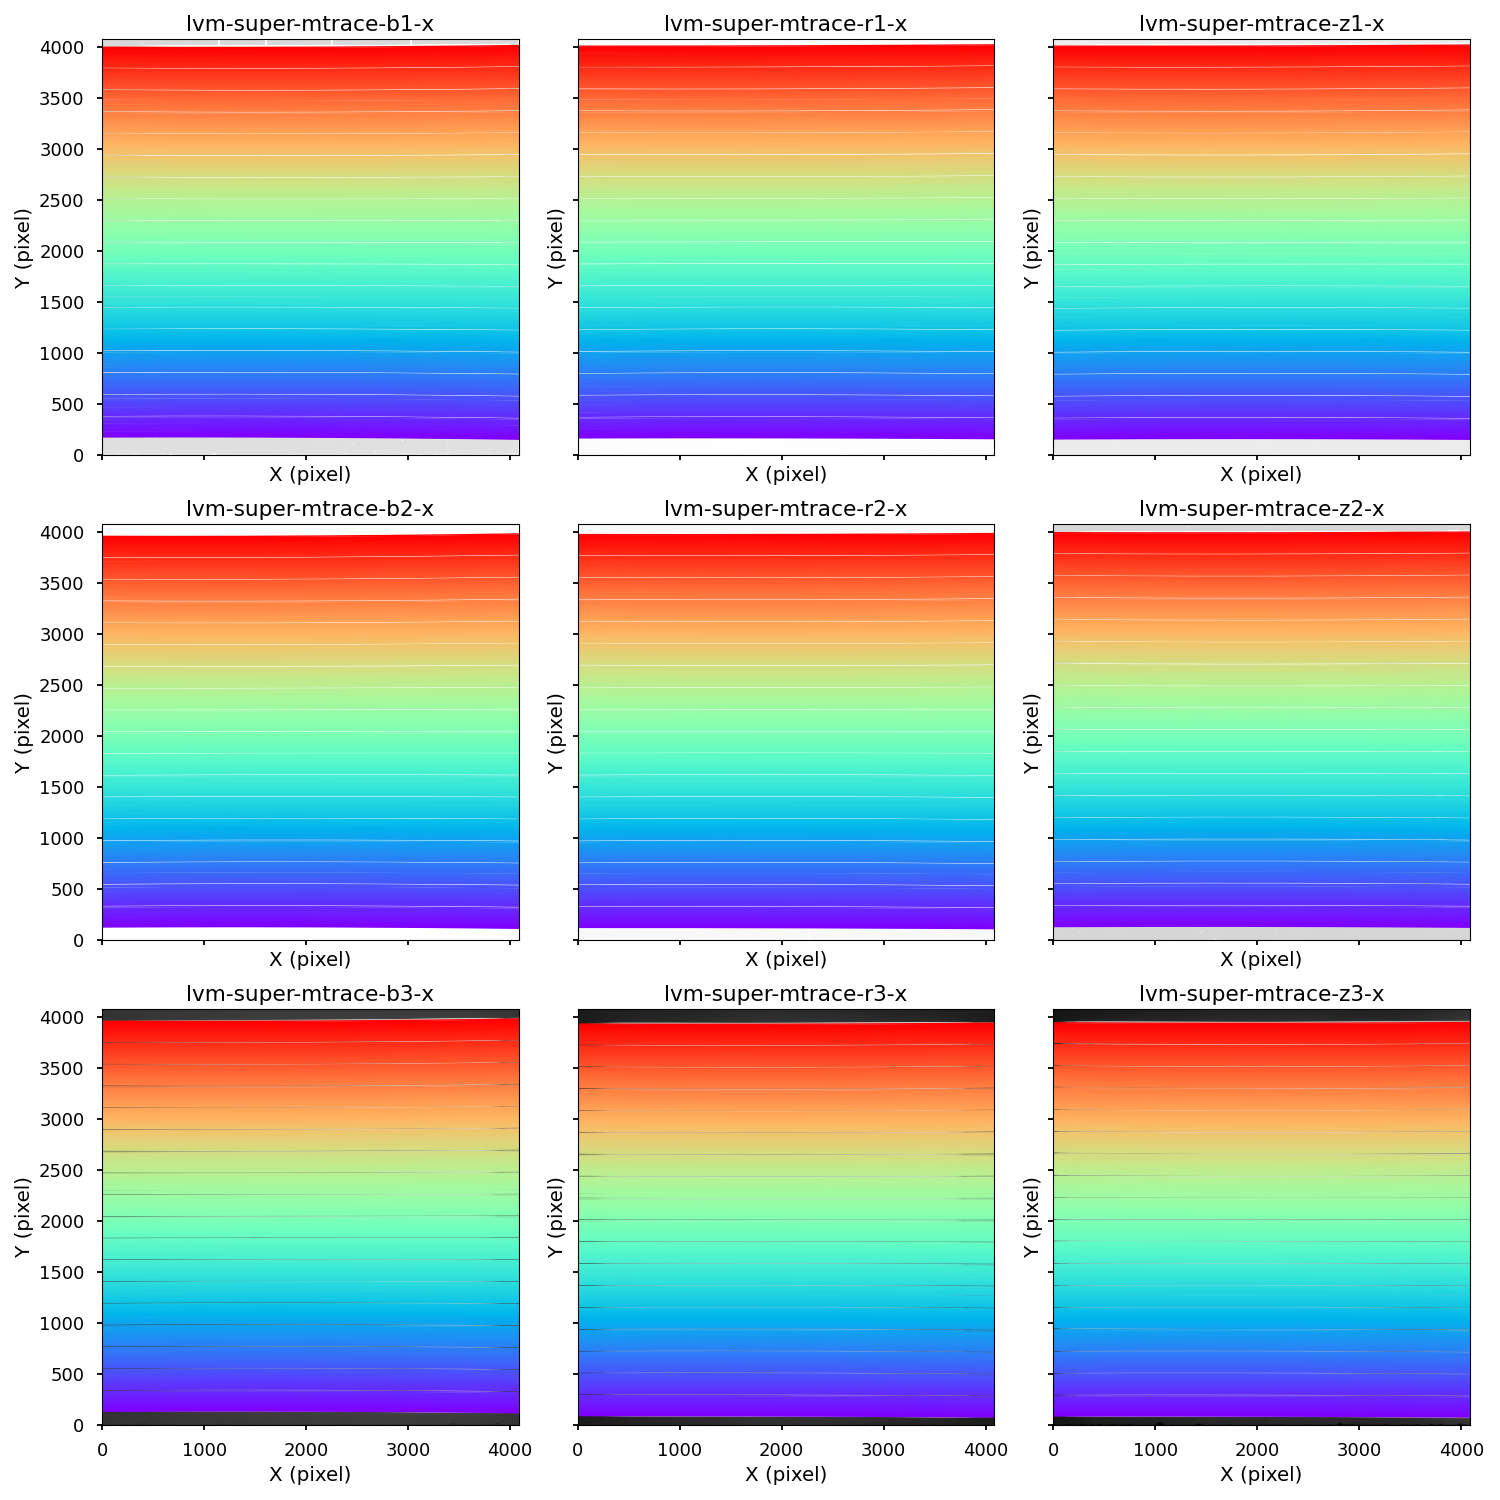

In [15]:
# tracing
traces = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="mtrace", exptime="x").sort_values("camera")

fig, axs = plt.subplots(3, 3, figsize=(15,15), sharex=True, sharey=True)
axs = axs.T.flatten()

for i, ax in enumerate(axs):
    trace_path = traces.path.iloc[i]
    
    ax.set_title(os.path.basename(trace_path).replace(".fits", ""))
    ax.set_xlabel("X (pixel)")
    ax.set_ylabel("Y (pixel)")

    trace = tracemask.TraceMask()
    trace.loadFitsData(trace_path)

    fiberflat = image.loadImage(trace_path.replace("mtrace", "mfiberflat"))

    fiberflat_data = fiberflat._data
    # fiberflat_data[fiberflat._mask] = np.nan

    norm = simple_norm(fiberflat_data, stretch="log", max_percent=95)
    ax.imshow(fiberflat_data, norm=norm, origin="lower", cmap="binary_r")

    for ifiber in range(trace._fibers):
        fiber = trace.getSpec(ifiber)
        ax.plot(fiber._pixels, fiber._data, color=plt.cm.rainbow(ifiber/trace._fibers), lw=1)

fig.tight_layout()

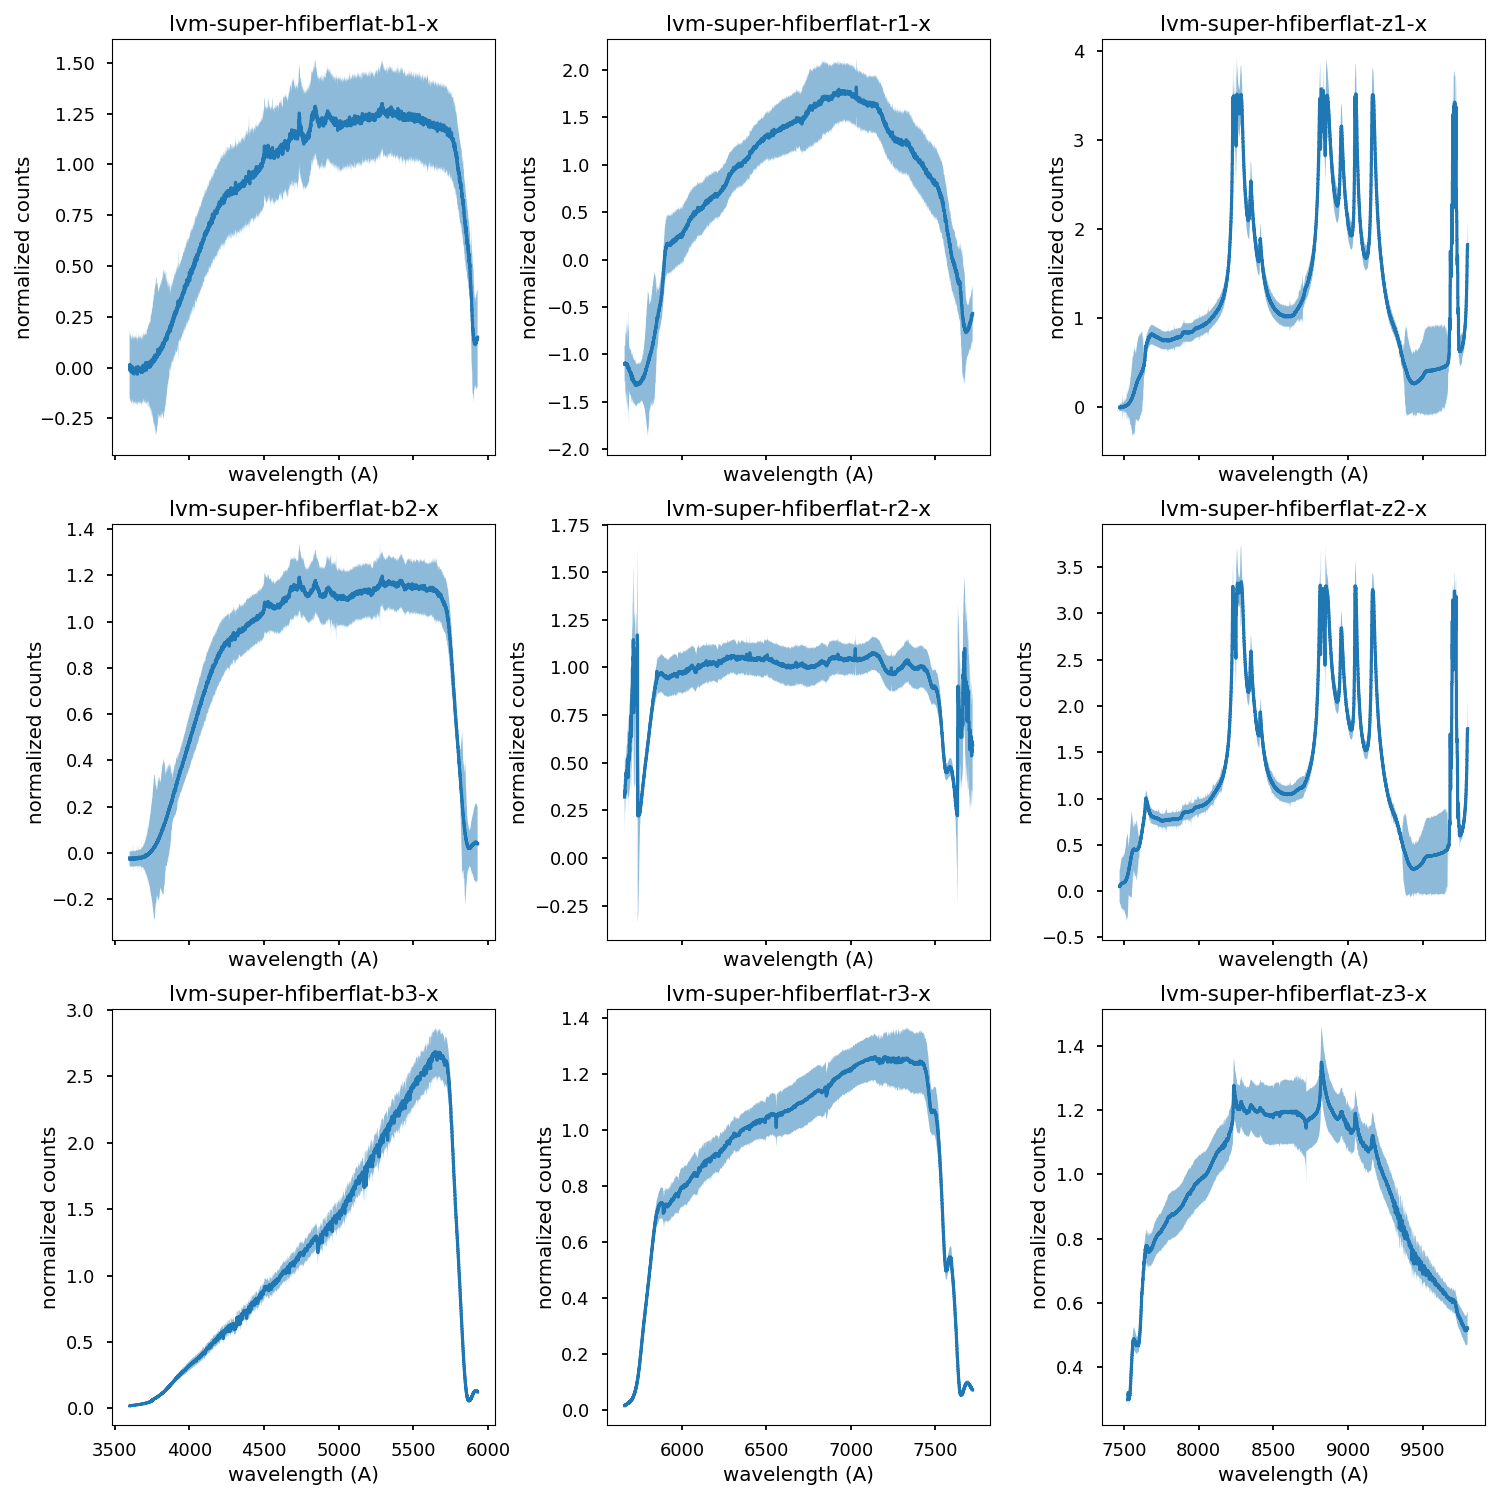

In [9]:
# fiberflats
fiberflats = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="hfiberflat", exptime="x").sort_values("camera")

fig, axs = plt.subplots(3, 3, figsize=(15,15), sharex="col", sharey=False)
axs = axs.T.flatten()
for i, ax in enumerate(axs):
    fiberflat_path = fiberflats.path.iloc[i]
    
    ax.set_title(os.path.basename(fiberflat_path).replace(".fits", ""))
    ax.set_xlabel("wavelength (A)")
    ax.set_ylabel("normalized counts")

    fiberflat = rss.RSS()
    fiberflat.loadFitsData(fiberflat_path)

    data = np.ma.masked_array(fiberflat._data, mask=fiberflat._mask)
    data = sigma_clip(data, sigma=3)
    data /= np.ma.median(data)

    flat_med = np.ma.median(data, axis=0)
    flat_std = np.ma.std(data, axis=0)
    
    ax.fill_between(fiberflat._wave, flat_med-flat_std, flat_med+flat_std, lw=0, fc="tab:blue", alpha=0.5)
    ax.step(fiberflat._wave, flat_med, color="tab:blue")

fig.tight_layout()

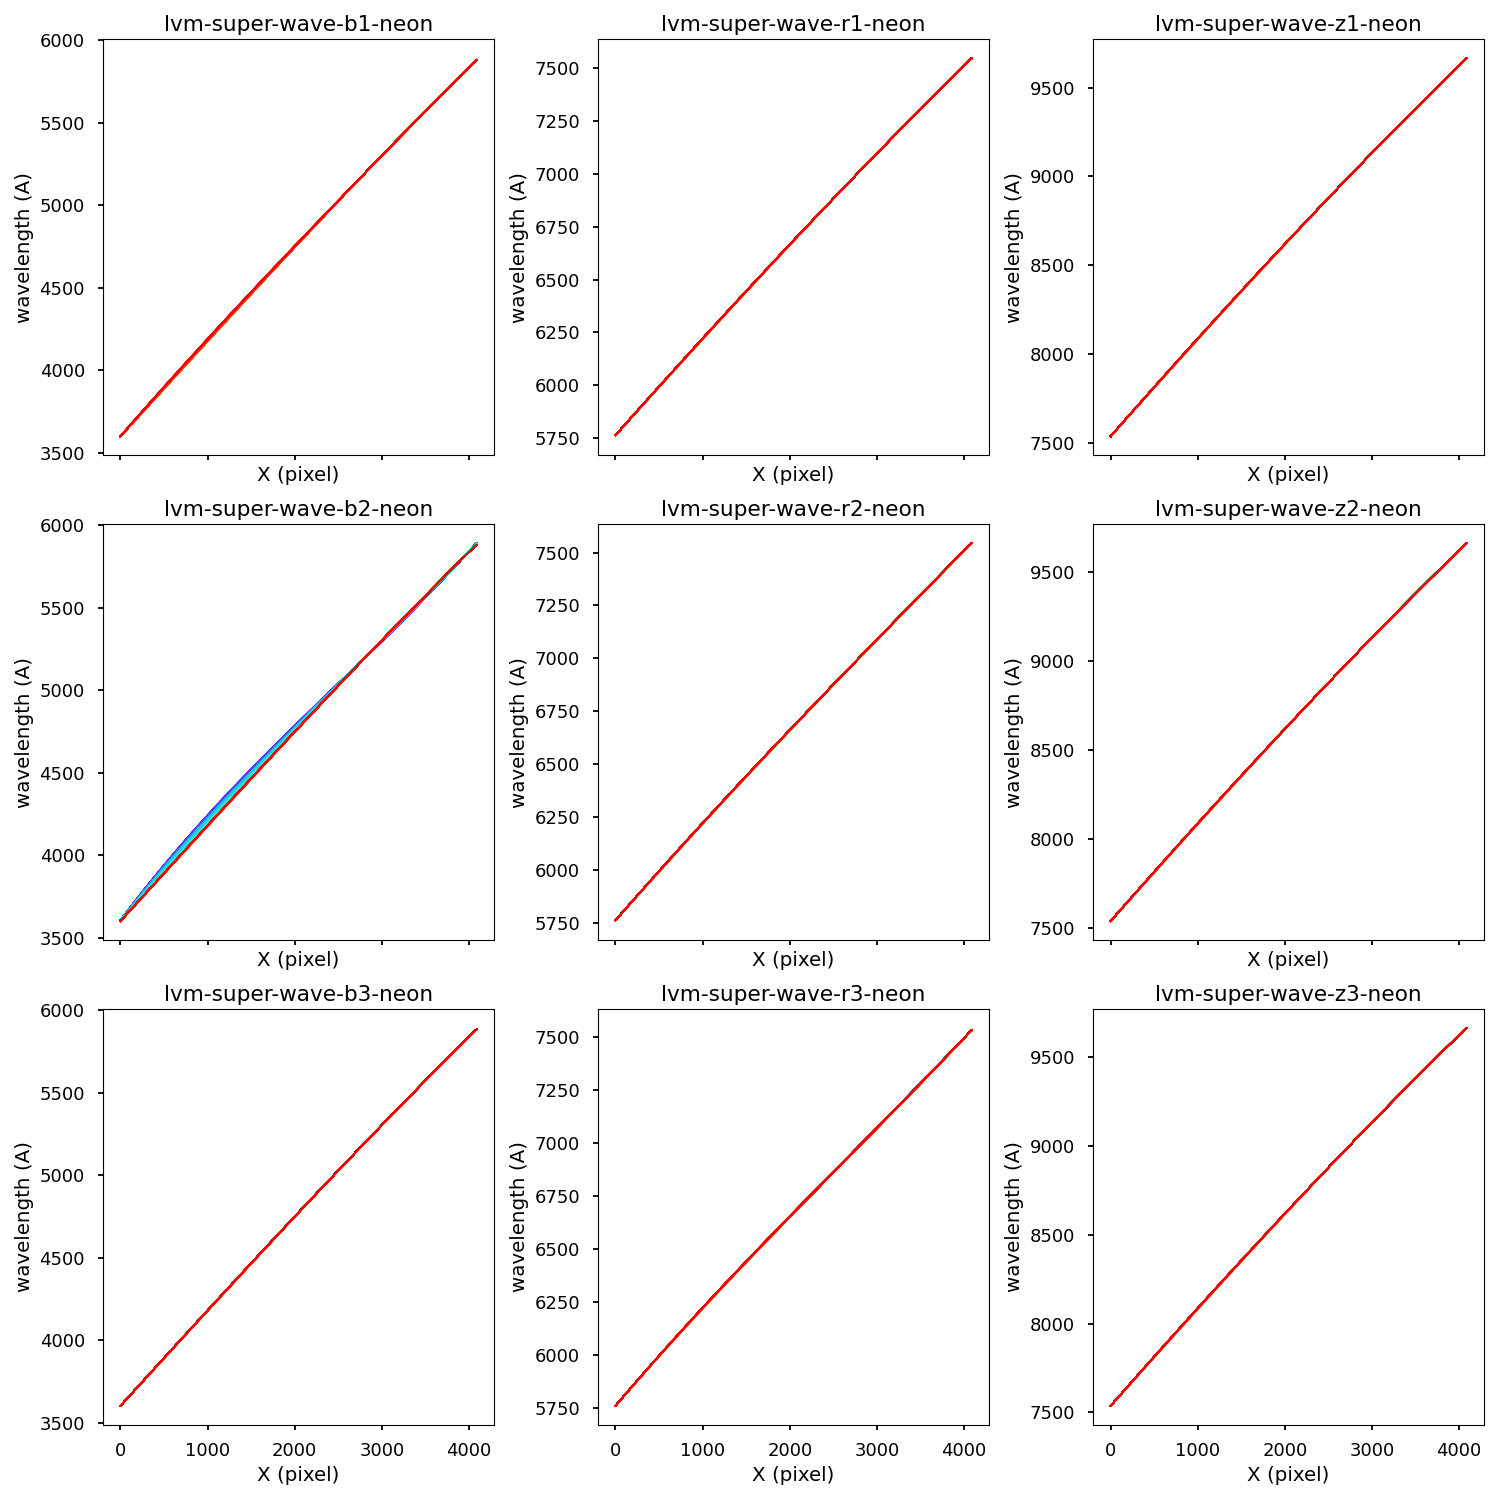

In [10]:
# arcs and wavelength solutions
from numpy.polynomial import Polynomial

lamps = "neon"

waves = get_masters_metadata(path_pattern=out_arc_path, mjd="super", kind="wave", lamps=lamps).sort_values("camera")

fig, axs = plt.subplots(3, 3, figsize=(15,15), sharex="col", sharey="col")
axs = axs.T.flatten()

wave_traces = {}
for i, ax in enumerate(axs):
    wave_path = waves.path.iloc[i]
    
    ax.set_title(os.path.basename(wave_path).replace(".fits", ""))
    ax.set_xlabel("X (pixel)")
    ax.set_ylabel("wavelength (A)")
    
    wave = tracemask.TraceMask()
    wave.loadFitsData(wave_path)
    
    wave_traces[waves.camera.iloc[i]] = wave._data

    for ifiber in range(wave._fibers):
        wave_trace = Polynomial(wave._coeffs[ifiber], domain=wave._pixels[[0,-1]])(wave._pixels)
        ax.step(wave._pixels, wave_trace, color=plt.cm.rainbow(ifiber/wave._fibers), lw=1)

fig.tight_layout()

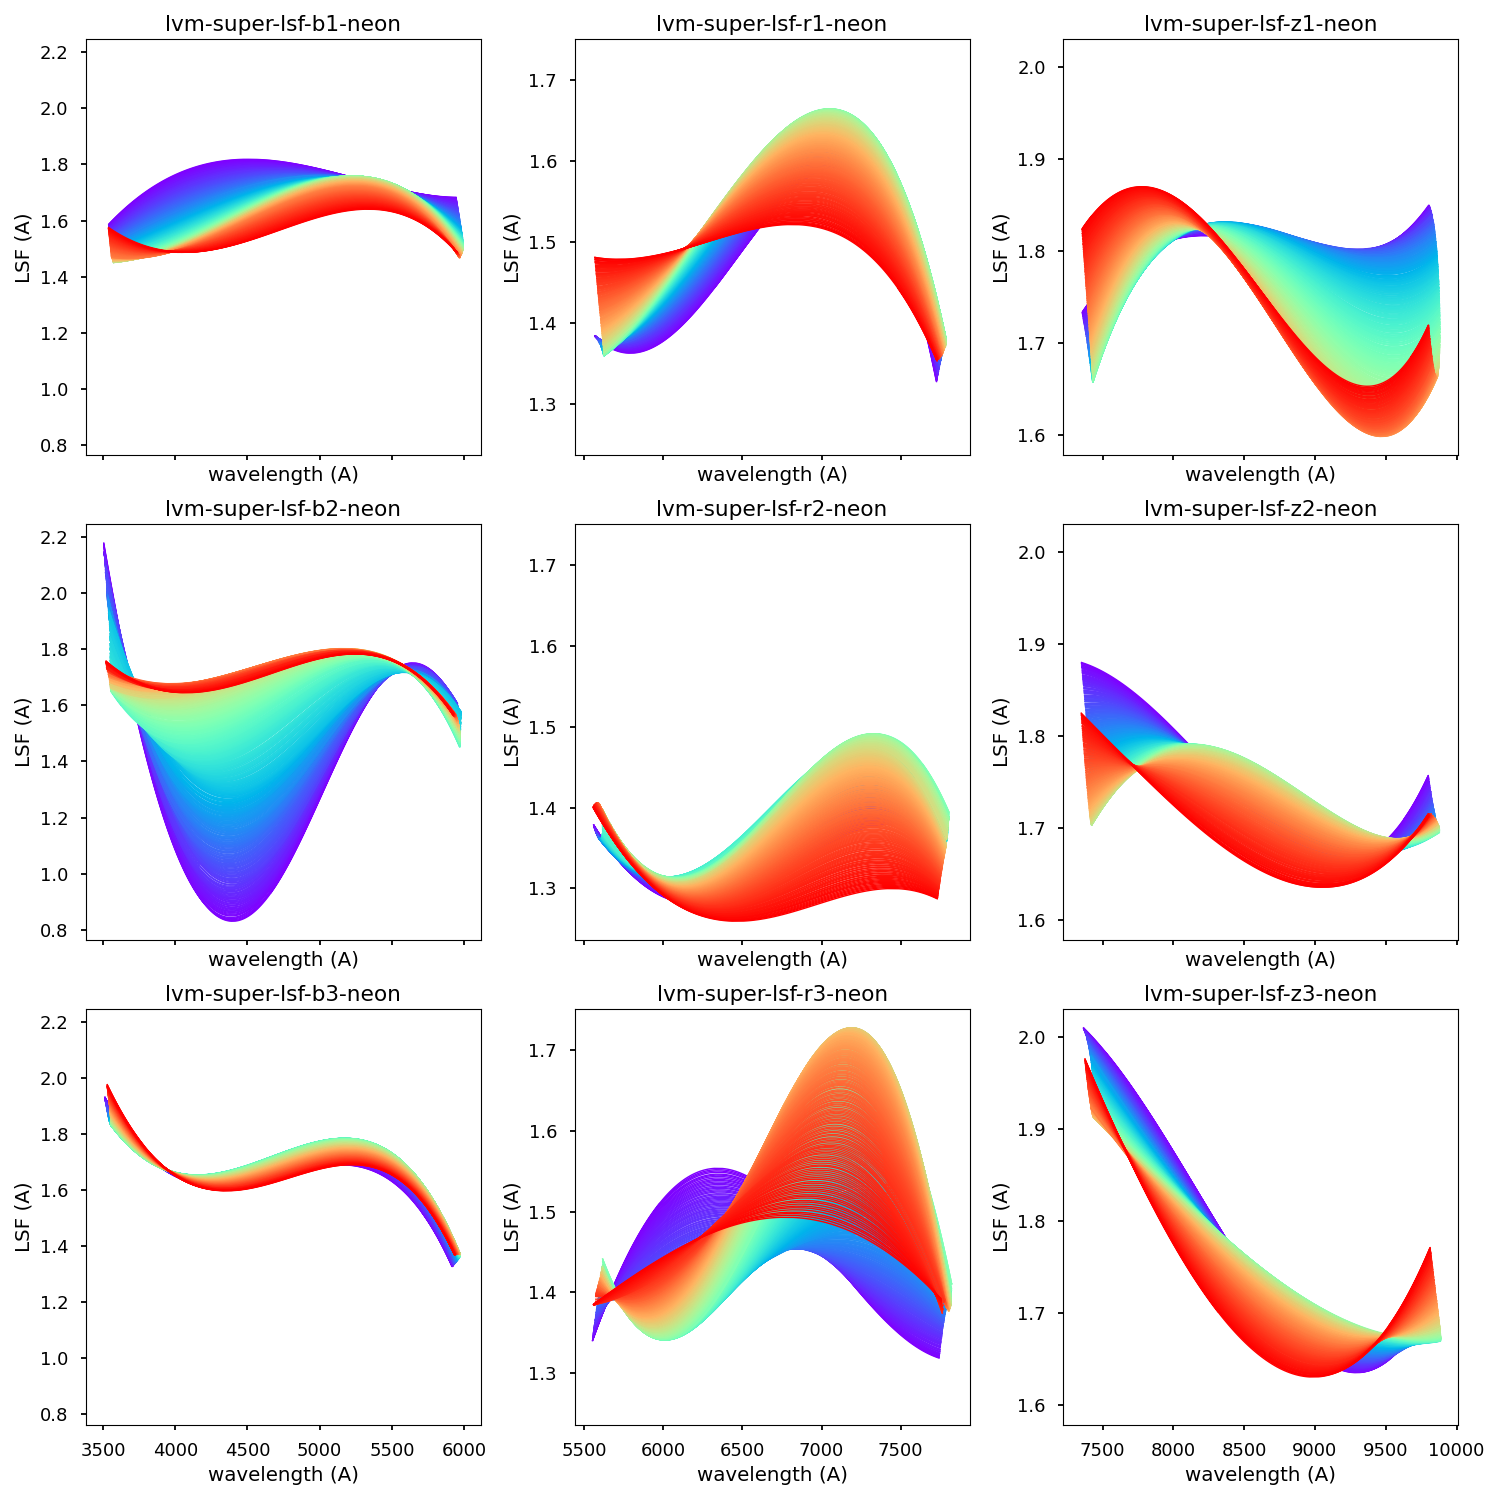

In [11]:
lsfs = get_masters_metadata(path_pattern=out_arc_path, mjd="super", kind="lsf", lamps=lamps).sort_values("camera")

fig, axs = plt.subplots(3, 3, figsize=(15,15), sharex="col", sharey="col")
axs = axs.T.flatten()

lsf_traces = {}
for i, ax in enumerate(axs):
    lsf_path = lsfs.path.iloc[i]
    
    ax.set_title(os.path.basename(lsf_path).replace(".fits", ""))
    ax.set_xlabel("wavelength (A)")
    ax.set_ylabel("LSF (A)")
    
    lsf = tracemask.TraceMask()
    lsf.loadFitsData(lsf_path)

    lsf_traces[waves.camera.iloc[i]] = lsf._data
    
    for ifiber in range(lsf._fibers):
        lsf_trace = Polynomial(lsf._coeffs[ifiber], domain=lsf._pixels[[0,-1]])(lsf._pixels)
        ax.step(wave_traces[lsfs.camera.iloc[i]][ifiber], lsf_trace, color=plt.cm.rainbow(ifiber/lsf._fibers), lw=1)

fig.tight_layout()

In [12]:
wave_ranges = pd.DataFrame({camera: np.median(wave, axis=0) for camera, wave in wave_traces.items()}).agg(["min","max"])
wave_ranges.loc["std", :] = pd.DataFrame({camera: np.median(wave, axis=1) for camera, wave in wave_traces.items()}).agg(["std"]).values
print(wave_ranges.to_string())

              b1           b2           b3           r1           r2           r3           z1           z2           z3
min  3566.707764  3544.239258  3546.674072  5613.507324  5605.453125  5603.474609  7413.612305  7407.928711  7426.436523
max  5979.502930  5965.625000  5960.517578  7771.583008  7780.133301  7800.576172  9860.550781  9857.114258  9865.906250
std    12.151607    12.677676    13.227664    18.162188    17.492628    16.812939    23.444168    23.421894    23.025734


In [13]:
lsf_ranges = pd.DataFrame({camera: np.median(lsf, axis=0) for camera, lsf in lsf_traces.items()}).agg(["min","max"])
lsf_ranges.loc["std", :] = pd.DataFrame({camera: np.median(lsf, axis=1) for camera, lsf in lsf_traces.items()}).agg(["std"]).values
print(lsf_ranges.to_string())

           b1        b2        b3        r1        r2        r3        z1        z2        z3
min  1.428613  1.473257  1.253435  1.060186  1.174260  1.038126  1.622229  1.677132  1.668259
max  1.755024  1.773845  1.910953  1.634676  1.474695  1.610704  1.825881  1.789861  1.969104
std  0.047988  0.103137  0.016422  0.021344  0.023515  0.026421  0.035025  0.010962  0.005183
